In [58]:
import os
import json
from tqdm import tqdm
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from pprint import pprint

import sys
sys.path.append(str(Path.cwd().parent/'scripts'))

from _aggregation_helpers import flexible_aggregate

In [59]:
root = Path.cwd().parent / 'results'

In [85]:
periods = {}

# for fn in tqdm([p for p in os.listdir(root / 'periods') if '2023-01' in p]):
# for fn in tqdm([p for p in os.listdir(root / 'periods') if '2022-07' in p]):
#     with open(root / 'periods' / fn, 'r') as f:
#         periods.update(json.load(f))

# with open(root / 'half-hourly' / '2024-03-22.json', 'r') as f:
with open(root / 'half-hourly' / '2023-04-05.json', 'r') as f:
    t = json.load(f)


In [86]:
agg = flexible_aggregate(t)

pprint(agg['nodal']['globals']['variables']['balancing_cost_savings'])
pprint(agg['eso']['globals']['variables']['balancing_cost_savings'])
pprint(agg['national']['globals']['variables']['balancing_cost_savings'])

1380103.1512610088
454349.08347645885
0.0


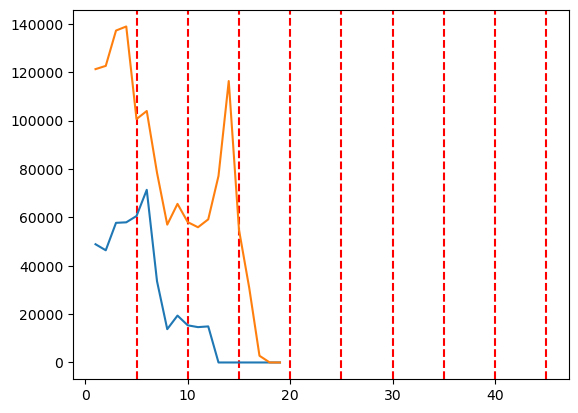

In [87]:
r = []
rn = []

for key, item in sorted(t.items()):
    r.append(item['eso']['globals']['variables']['balancing_cost_savings'])
    rn.append(item['nodal']['globals']['variables']['balancing_cost_savings'])

# dt = [pd.Timestamp.fromtimestamp(int(k)) for k in t.keys()]
dt = [i+1 for i in range(len(r))]

r = pd.Series(r, dt).sort_index()
rn = pd.Series(rn, dt).sort_index()

for l in range(5, 50, 5):
    plt.axvline(x=l, color='r', linestyle='--')

plt.plot(r.index, r.values)
plt.plot(rn.index, rn.values)

In [8]:
agg = flexible_aggregate(periods)

In [9]:
from pprint import pprint

pprint(agg['nodal']['globals'])
pprint(agg['eso']['globals'])
pprint(agg['national']['globals'])

{'variables': {'balancing_cost': 0.0,
               'balancing_cost_savings': 459512.49132648687,
               'cfd_cost': -231608.44894282715,
               'cfd_cost_savings': -203071.41352821485,
               'congestion_rent': -904417.5729748989,
               'congestion_rent_savings': 904417.5729790553,
               'wholesale_cost': 11338899.046410682,
               'wholesale_cost_savings': -62650.56478436105}}
{'variables': {'balancing_cost': 140362.85588154694,
               'balancing_cost_savings': 319149.6354449399,
               'cfd_cost': -202791.4662419687,
               'cfd_cost_savings': -231888.3962290733,
               'congestion_rent': -507152.3660840234,
               'congestion_rent_savings': 507152.3660881799,
               'wholesale_cost': 11336334.039771477,
               'wholesale_cost_savings': -60085.55814515613}}
{'variables': {'balancing_cost': 459512.49132648687,
               'balancing_cost_savings': 0.0,
               'cfd_cos

In [63]:
import pypsa
path = Path.cwd().parent / 'resources' / 'live_data' / '2023-04-05_17'

neso = pypsa.Network(path / 'network_s_eso_solved.nc')
nnodal = pypsa.Network(path / 'network_s_nodal_solved.nc')

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\lukas\\OneDrive\\Desktop\\projects\\nodal\\LMP\\resources\\live_data\\2023-04-05_17\\network_s_eso_solved.nc'

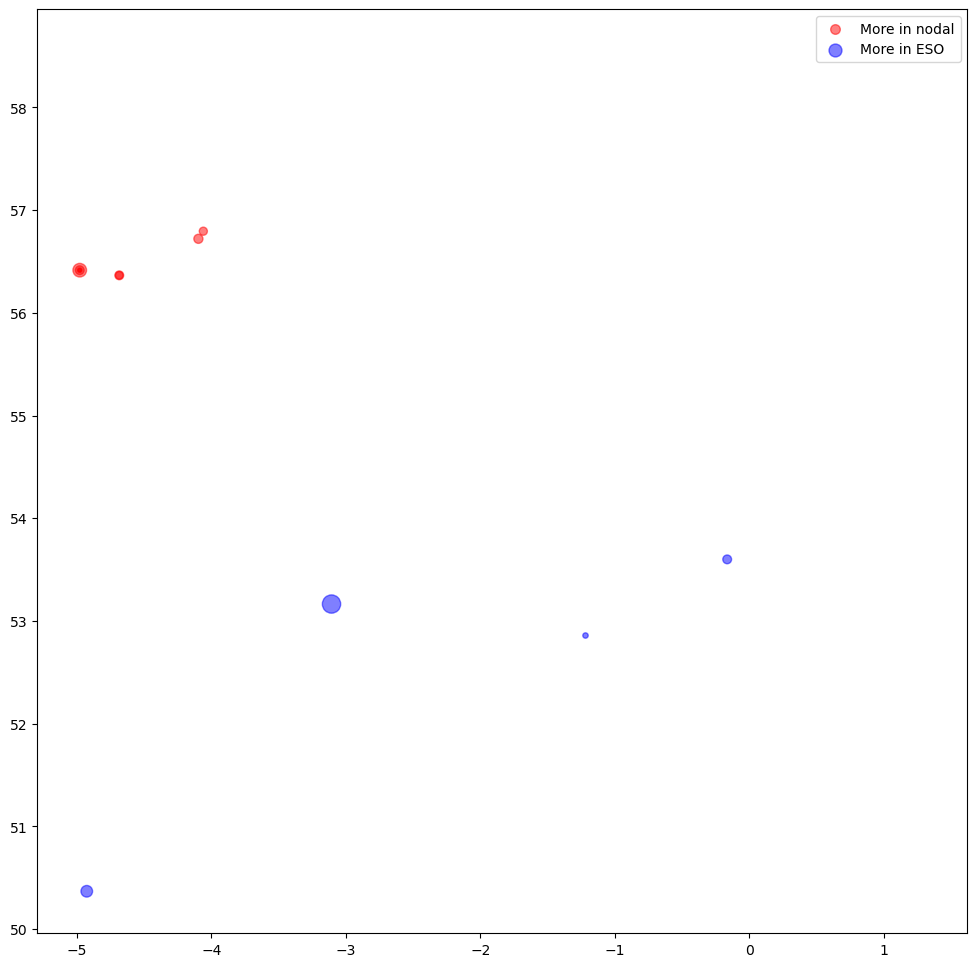

298.40736372980064 298.40736371515413


In [ ]:
g = pd.concat((
    nnodal.generators.bus,
    nnodal.generators.carrier,
    nnodal.generators_t.p.iloc[0].rename('nodal_dispatch'),
    neso.generators_t.p.iloc[0].rename('zonal_dispatch'),
), axis=1)

g = g.loc[g['bus'] != '']

g['more_in_eso'] = (g['zonal_dispatch'] - g['nodal_dispatch']).clip(0)
g['more_in_nodal'] = (g['nodal_dispatch'] - g['zonal_dispatch']).clip(0)

g['x'] = g.bus.apply(lambda x: nnodal.buses.loc[x].x)
g['y'] = g.bus.apply(lambda x: nnodal.buses.loc[x].y)

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

ax.scatter(g.x, g.y, s=g.more_in_nodal, c='r', alpha=0.5, label='More in nodal')
ax.scatter(g.x, g.y, s=g.more_in_eso, c='b', alpha=0.5, label='More in ESO')

ax.legend()
plt.show()

print(g.more_in_eso.sum(), g.more_in_nodal.sum())

In [37]:
print(g.sort_values(by='more_in_eso', ascending=False).head(20)[['carrier', 'more_in_eso']])
print(g.sort_values(by='more_in_nodal', ascending=False).head(20)[['carrier', 'more_in_nodal']])

           carrier  more_in_eso
Generator                      
COSO-1         gas   395.900326
CLDNW-1     onwind   155.000000
LNMTH-2       coal   130.000000
CLDSW-1     onwind    81.000000
RRWW-1     offwind    78.000000
RREW-1     offwind    71.000000
CLDCW-1     onwind    11.987162
MINSW-1     onwind     8.000000
HRTL-1     nuclear     0.000000
HOWBO-2    offwind     0.000000
KLGLW-1       wind     0.000000
KILLPG-2      CCGT     0.000000
KILLPG-1      CCGT     0.000000
KILBW-1     onwind     0.000000
KENNW-1       wind     0.000000
HOWBO-1    offwind     0.000000
KEAD-2         gas     0.000000
HUMR-1         gas     0.000000
KEAD-1         gas     0.000000
HOWBO-3    offwind     0.000000
                carrier  more_in_nodal
Generator                             
ROCK-1              gas     164.895241
FOYE-2              PHS     150.000000
GRMO-1              CHP     142.000000
CAS-BEU01  hydro-scheme      74.000000
CAS-CON01  hydro-scheme      66.182666
CAS-MOR01  hydro-scheme